In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from os import listdir
from os.path import isfile, join
import ccg_filter
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

font = {'weight' : 'bold', 'size' : 14}
matplotlib.rc('font', **font)

# Define functions

In [2]:
def decimalDate_ymd (year, month, day=15):
    """ Convert a date to a fractional year. """
    pd_date = pd.to_datetime(year*10000 + month*100 + day, format='%Y%m%d')
    
    return pd_date.dt.year + pd_date.dt.dayofyear / [366 if x else 365 for x in pd_date.dt.is_leap_year]

In [3]:
def decimalDate_datetime (datetime):
    """ Convert a date to a fractional year. """
    
    return datetime.dt.year + datetime.dt.dayofyear / [366 if x else 365 for x in datetime.dt.is_leap_year]

In [13]:
def plot_fit (xp, yp, x0, y1, y2, harmonics, resid_from_func, resid_smooth, resid_trend, station):
    """ Print fit curve and filter curve. """
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(15,14))
#     print(axes.shape)
    (ax1, ax2, ax3, ax4) = axes

    ax1.plot(xp, yp,'ko', ms=6, label = 'raw data')
    ax1.plot(x0, y1,'r', label = 'fitted curve (2 deg + 4 harmonic)')
    ax1.plot(x0, y2,'b', label = 'polynomial part')
    ax1.set_ylim(yp.min()-1,yp.max()+4)
    ax1.set_ylabel('CO2, ppm')
    ax1.legend(loc='upper left', fontsize='small')
    ax1.set_title("a. Fitted curve")

    ax2.plot(x0, harmonics,'g', label = 'harmonic part')
    ax2.set_ylim(harmonics.min()-1,harmonics.max()+1)
    ax2.set_ylabel('CO2, ppm')
    ax2.legend(loc='upper left', fontsize='small')
    ax2.set_title("b. Harmonic part")

    ax3.plot(x0, resid_from_func,'ko', label = 'raw - fitted curve')
    ax3.plot(x0, resid_smooth,'r', label = 'short term cutoff filter')
    ax3.plot(x0, resid_trend,'b', label = 'long term cutoff filter')
    ax3.axhline(y=0, linestyle='--', color='k')
    ax3.set_ylim(resid_from_func.min()-1,resid_from_func.max()+2)
    ax3.set_ylabel('CO2, ppm')
    ax3.legend(loc='upper left', fontsize='small')
    ax3.set_title("c. Residuals")

    ax4.plot(xp, yp,'ko', ms=6, label = 'raw data')
    ax4.plot(x0, y1 + resid_smooth,'r', label = 'fitted curve + short term cutoff filter')
    ax4.plot(x0, y2 + resid_trend,'b', label = 'polynomial part + long term cutoff filter')
    ax4.set_ylim(yp.min()-1,yp.max()+4)
    ax4.set_ylabel('CO2, ppm')
    ax4.set_xlabel('year')
    ax4.legend(loc='upper left', fontsize='small')
    ax4.set_title("d. Combine fit fuction with filtered residucals")
    
    fig.suptitle("CO2 fit curve and filter curve at " + station + " station", fontsize=20)
    plt.savefig("figure2.png")

In [14]:
def plot_fit_wdcgg (xp, yp, y1, y2, harmonics, resid_from_func, station):
    """ Print fit curve and filter curve. """
    fig, axes = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(15,12))
#     print(axes.shape)
    (ax1, ax2, ax3) = axes

    ax1.plot(xp, yp,'ko', ms=6, label = 'raw data')
    ax1.plot(xp, y1,'r', label = 'fitted curve (trend + 3 harmonic)')
    ax1.plot(xp, y2,'b', label = 'trend')
    ax1.set_ylim(yp.min()-1,yp.max()+4)
    ax1.set_ylabel('CO2, ppm')
    ax1.legend(loc='upper left', fontsize='small')
    ax1.set_title("a. Fitted curve")

    ax2.plot(xp, harmonics,'g', label = 'harmonic part')
    ax2.set_ylim(harmonics.min()-1,harmonics.max()+1)
    ax2.set_ylabel('CO2, ppm')
    ax2.legend(loc='upper left', fontsize='small')
    ax2.set_title("b. Harmonic part")

    ax3.plot(xp, resid_from_func,'ko', label = 'raw - fitted curve')
    ax3.axhline(y=0, linestyle='--', color='k')
    ax3.set_ylim(resid_from_func.min()-1,resid_from_func.max()+2)
    ax3.set_ylabel('CO2, ppm')
    ax3.legend(loc='upper left', fontsize='small')
    ax3.set_title("c. Residuals")
    
    fig.suptitle("CO2 fit curve and filter curve at " + station + " station", fontsize=20)

In [16]:
def plot_growthrate(xp, trendp, x0, trend_spl, trend_der1, station):
    """ Print growth rate curve. """
    fig,axes = plt.subplots(2,1, sharex=True, figsize = (15,10))
#     print(axes.shape)
    
    (ax1, ax2) = axes
    
    ax1.plot(xp, trendp, 'ko', label = "trend points")
    ax1.plot(x0, trend_spl, 'b',label = "interpolated cubic spline curve")
    ax1.set_ylabel("CO2, ppm")
    ax1.legend()
    ax1.set_title("a. Trend")

    ax2.plot(x0, trend_der1,'mo', label="derivative of the spline curve" )
    ax2.set_xlabel("year")
    ax2.set_ylabel("CO2 ppm/year")
    ax2.legend()
    ax2.set_title("b. Growth rate")
    
    fig.suptitle("CO2 growth rate at " + station + " station", fontsize=20)
    plt.savefig("figure3.png")

In [17]:
def plot_growthrate_wdcgg(xp, growth_rate, station):
    """ Print growth rate curve. """
    
    fig = plt.figure( figsize = (15,6))
    ax = plt.axes()

    ax.plot(xp, growth_rate,'mo', label="annual increase" )
    ax.set_xlabel("year")
    ax.set_ylabel("CO2 ppm/year")
    ax.legend()
    ax.set_title("CO2 annual increase at " + station + " station", fontsize=20)
    

In [11]:
def apply_fit_filter(IN_PATH, file, OUT_PATH, ifplot=1, station_patten = "_brw_", station = "BRW", source = "", 
                     from2000 = True):
    """ apply fit fuction and filter, and save the output as csv format """
    ################################################################################################ 
    # mark if it is measured in shipboard
    ################################################################################################ 
    pre_filename = file.split(".")[0]
    shipboard = 0
    if any(item in pre_filename for item in ['shipboard', 'poc8', 'scs8']):
        shipboard = 1
    
    ################################################################################################ 
    # read data and primary data clean
    ################################################################################################ 
    if source == "wdcgg":
        dat = pd.read_table(IN_PATH+file, delimiter="\s+", skiprows=24)
        dat = dat.reset_index()
        dat = dat.iloc[:,0:3]
        dat.columns = ['yy','mm','co2']
    else:
        dat = pd.read_table(IN_PATH+file, delimiter="\s+")

    # set outlier to NaN
    dat.loc[(dat["co2"]>1000) | (dat["co2"]<0),"co2"] = np.nan
    dat = dat.loc[~np.isnan(dat.co2)]
    
    # get monthly mean
    df_monthly = dat.groupby(["yy","mm"])["co2"].mean().sort_index(ascending=True)

    # trim leading and trailing NAs 
    first_valid = df_monthly[df_monthly.notnull()].index[0]
    last_valid = df_monthly[df_monthly.notnull()].index[-1]
    df_monthly = df_monthly.loc[first_valid:last_valid]

    # set date and decimal date
    df_monthly = df_monthly.reset_index()
    df_monthly["date"] = pd.to_datetime(df_monthly.yy*10000+df_monthly.mm*100+15,format='%Y%m%d')
    df_monthly["decimalyear"] = decimalDate_ymd(df_monthly.yy, df_monthly.mm, 15)
    if from2000 == True:
        df_monthly = df_monthly[df_monthly.date > "2000-1-1"]
    df_monthly = df_monthly.set_index("date")
    ################################################################################################ 
    # apply fit fuction and filter 
    ################################################################################################ 
    xp = df_monthly["decimalyear"]
    yp = df_monthly["co2"]

    # skip the station which has less than 12 monthes data
    if len(xp) < 12:
        print(f"There is only {len(xp)} monthes data at this station ({pre_filename}), ...... skip")
        return

    # set shortterm cutoff as 200 for the measurement on shipboard
    if shipboard == 0:
        try:
            filt = ccg_filter.ccgFilter(xp, yp, shortterm=80, longterm=667, sampleinterval=0,
                                numpolyterms=3, numharmonics=4, timezero=-1, gap=0, use_gain_factor=False, debug=False,)
        except:
            print(f"error at this station ({pre_filename})")
    else:
        #https://www.esrl.noaa.gov/gmd/webdata/ccgg/trends/co2_DEconfig.txt
        try:
            filt = ccg_filter.ccgFilter(xp, yp, shortterm=200, longterm=667, sampleinterval=0,
                                numpolyterms=3, numharmonics=4, timezero=-1, gap=0, use_gain_factor=False, debug=False,)
        except:
            print(f"error at this station ({pre_filename})")
    
    # check if the numharmonics is appropriate
    # e.g. station FPK, no 62, gives extreme harmonic/seasonality, the numharmonics needs to reduce
    x0 = filt.xinterp
    harmonics = filt.getHarmonicValue(x0)
    if abs(harmonics.sum()) > 500:
        print(f"The numharmonics setting causes extreme output at this station ({pre_filename}), ...... skip")
        print(f"The harmonics are: {harmonics}")
        print(f"The solution is to reduce numharmonics, e.g. 3 or 2, here we just exclude this station data")
        return
    ################################################################################################ 
    # estimate co2 during full period 
    ################################################################################################ 
    df_fullmonthly = df_monthly.resample('M').mean().reset_index()
    df_fullmonthly.date = df_fullmonthly.date.apply(lambda dt: dt.replace(day=15))
    df_fullmonthly.decimalyear = decimalDate_ymd(df_fullmonthly.date.dt.year, df_fullmonthly.date.dt.month, 15)

    # for fit plot
    x0 = df_fullmonthly.decimalyear
    y1 = filt.getFunctionValue(x0)
    y2 = filt.getPolyValue(x0)
    y3 = filt.getSmoothValue(x0)
    y4 = filt.getTrendValue(x0)
    harmonics = filt.getHarmonicValue(x0)
    resid_from_func = df_fullmonthly.co2 - y1
    resid_smooth = y3 - y1
    resid_trend = y4 -y2
    if ifplot and station_patten in pre_filename:
        plot_fit(xp, yp, x0, y1, y2, harmonics, resid_from_func, resid_smooth, resid_trend, station)

    # for growth rate plot
    trendp = filt.getTrendValue(xp)
    tck = sp.interpolate.splrep(x0, y4)
    trend_spl = sp.interpolate.splev(x0, tck)
    trend_der1 = sp.interpolate.splev(x0, tck, der=1)
    if ifplot and station_patten in pre_filename:
        plot_growthrate(xp, trendp, x0, trend_spl, trend_der1, station)
    ################################################################################################    
    # save the file
    ################################################################################################ 
    df_fullmonthly["polypart"] = y2
    df_fullmonthly["harmpart"] = harmonics
    df_fullmonthly["resid"] = resid_from_func
    df_fullmonthly["resid_smooth"] = resid_smooth
    df_fullmonthly["resid_trend"] = resid_trend
    df_fullmonthly["growth_rate"] = trend_der1

    df_fullmonthly.to_csv(OUT_PATH + pre_filename + "_fit_filter.csv", header=True,index=False, na_rep= "NaN")


# Apply fit function and filter for Carbon tracker obsversion data
### (<font color=red>This cell can not be run in github, due to the input data is too large to upload to github</font>)

There is only 5 monthes data at this station (co2_dvv_tower-insitu_60_allvalid), ...... skip
The numharmonics setting causes extreme output at this station (co2_fpk_surface-insitu_60_allhours), ...... skip
The harmonics are: [-530.72385151 -517.5695972  -537.05001313 -525.41696658 -532.74188872
 -557.32706436 -274.62797647 1467.29790842 1822.81515052   16.50120464
 -573.10627394 -517.63317596 -530.64585594 -536.16597425 -520.98684666
 -541.64746416]
The solution is to reduce numharmonics, e.g. 3 or 2, here we just exclude this station data
There is only 8 monthes data at this station (co2_gat_surface-insitu_425_allvalid), ...... skip
There is only 11 monthes data at this station (co2_gci01_tower-insitu_60_allvalid), ...... skip
There is only 11 monthes data at this station (co2_htm_tower-insitu_424_allvalid-150magl), ...... skip
There is only 7 monthes data at this station (co2_inx03_surface-insitu_60_allhours), ...... skip
There is only 5 monthes data at this station (co2_inx04_surfac

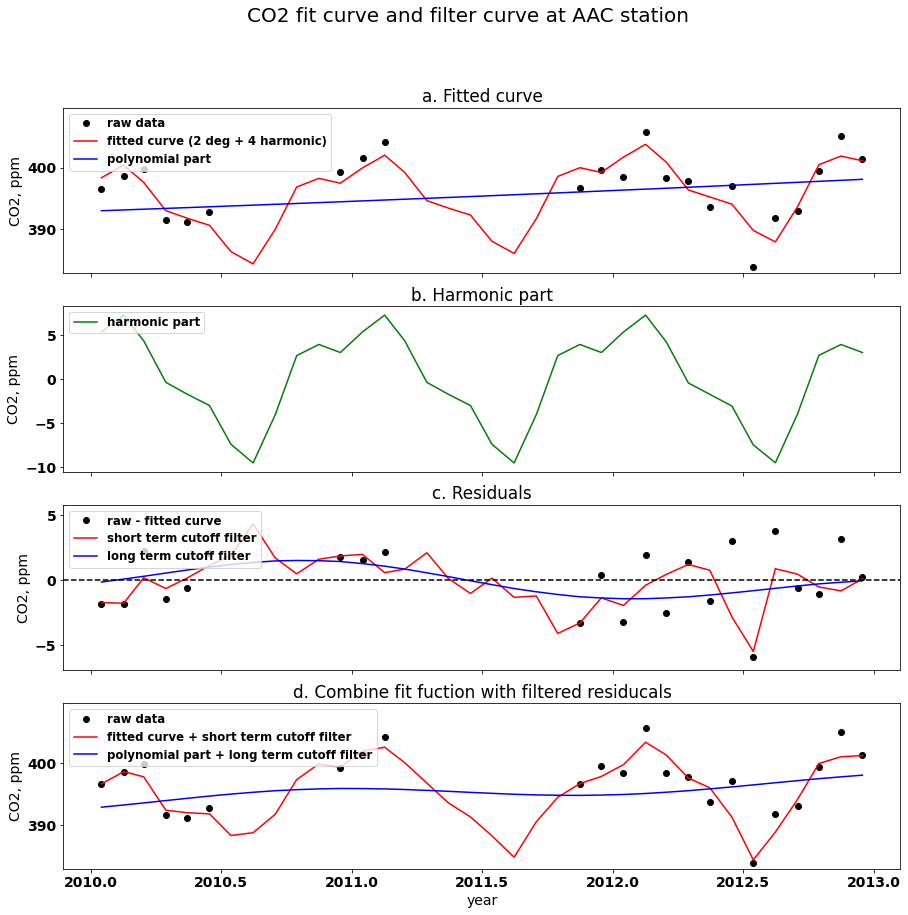

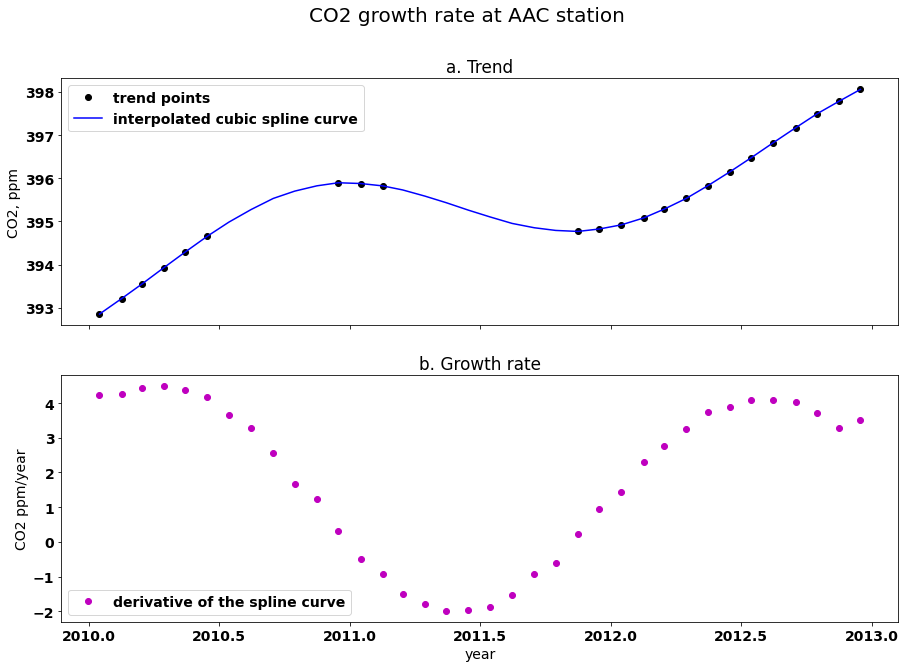

In [18]:
# set path of input and output
IN_PATH = "D:\\MyData\\jupter\\icos\\ctracker_obs\\input\\"
OUT_PATH = "D:\\MyData\\jupter\\icos\\ctracker_obs\\output\\"

# decide if plot, and which station
ifplot = 1
station_patten = "_aac_"
station = "AAC"

# apply fit function and filter to CO2 data at each station
filenames = listdir(IN_PATH)
for file in filenames:
    apply_fit_filter(IN_PATH, file, OUT_PATH, ifplot, station_patten, station)

# Apply fit function and filter for WDCGG obsversion data from 2000

There is only 0 monthes data at this station (avi417n0), ...... skip
There is only 0 monthes data at this station (ber255n0), ...... skip
There is only 0 monthes data at this station (cmo445n0), ...... skip
There is only 0 monthes data at this station (goz636n0), ...... skip
There is only 0 monthes data at this station (jbn762s0), ...... skip
There is only 0 monthes data at this station (kot276n0), ...... skip
There is only 0 monthes data at this station (kps646n0), ...... skip
There is only 0 monthes data at this station (kyz240n0), ...... skip
There is only 0 monthes data at this station (mbc476n0), ...... skip
There is only 0 monthes data at this station (opw448n0), ...... skip
There is only 6 monthes data at this station (poc835s0), ...... skip
There is only 0 monthes data at this station (scs803n0), ...... skip
There is only 0 monthes data at this station (scs806n0), ...... skip
There is only 0 monthes data at this station (scs809n0), ...... skip
There is only 0 monthes data at th

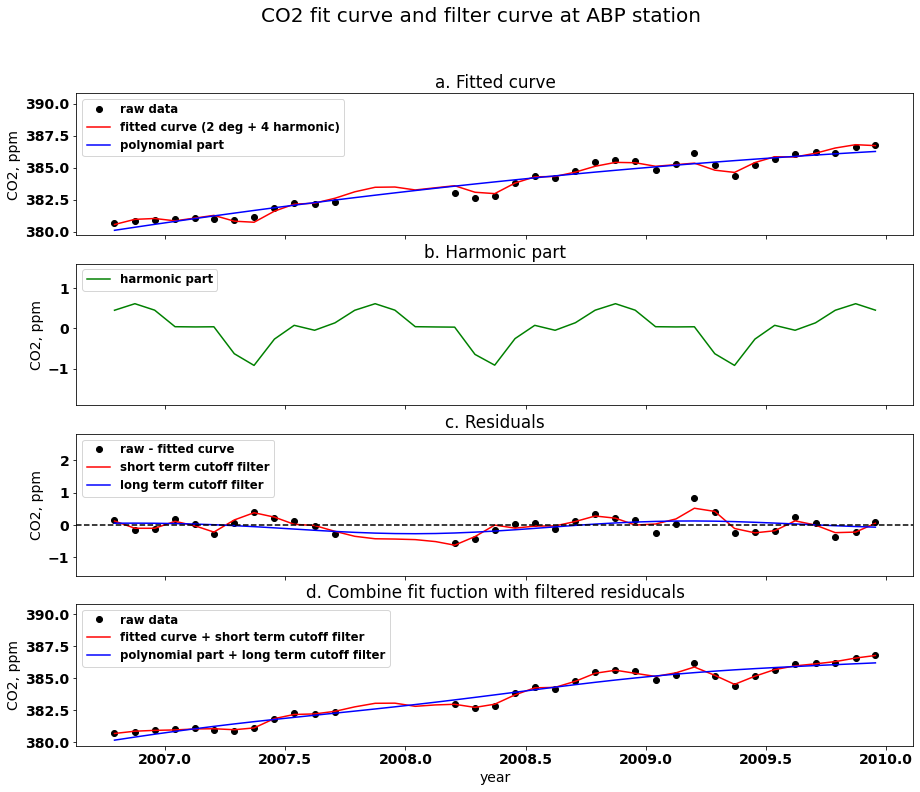

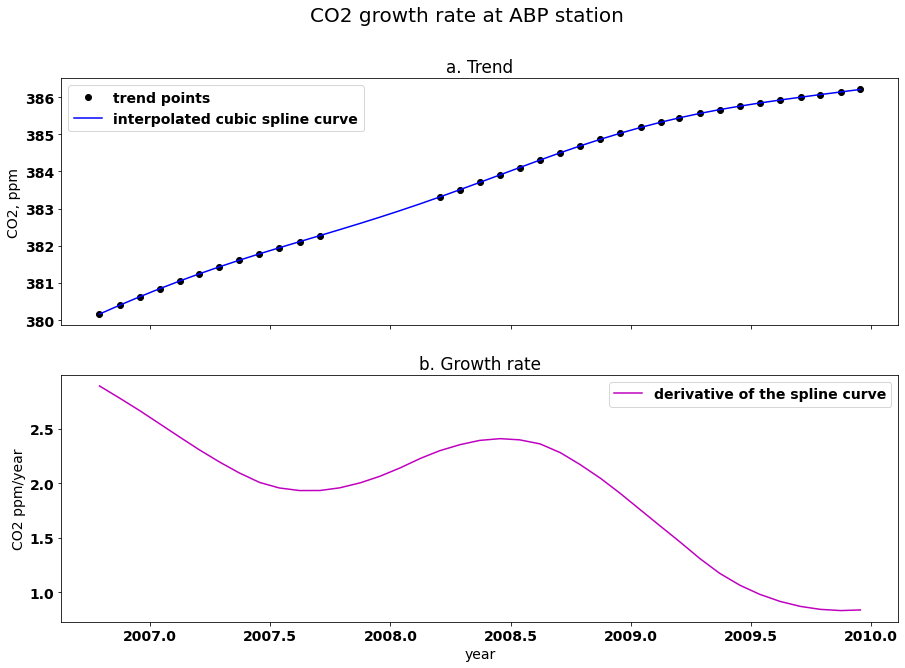

In [81]:
# set path of input and output
IN_PATH = "D:\\MyData\\jupter\\icos\\wdcgg_obs\\input\\"
OUT_PATH = "D:\\MyData\\jupter\\icos\\wdcgg_obs\\outputfrom2000\\"

# decide if plot, and which station
ifplot = 1
station_patten = "abp"
station = "ABP"

# apply fit function and filter to CO2 data at each station
filenames = listdir(IN_PATH)
for file in filenames:
    apply_fit_filter(IN_PATH, file, OUT_PATH, ifplot, station_patten, station, source="wdcgg")

# Apply fit function and filter for WDCGG obsversion data from 1968

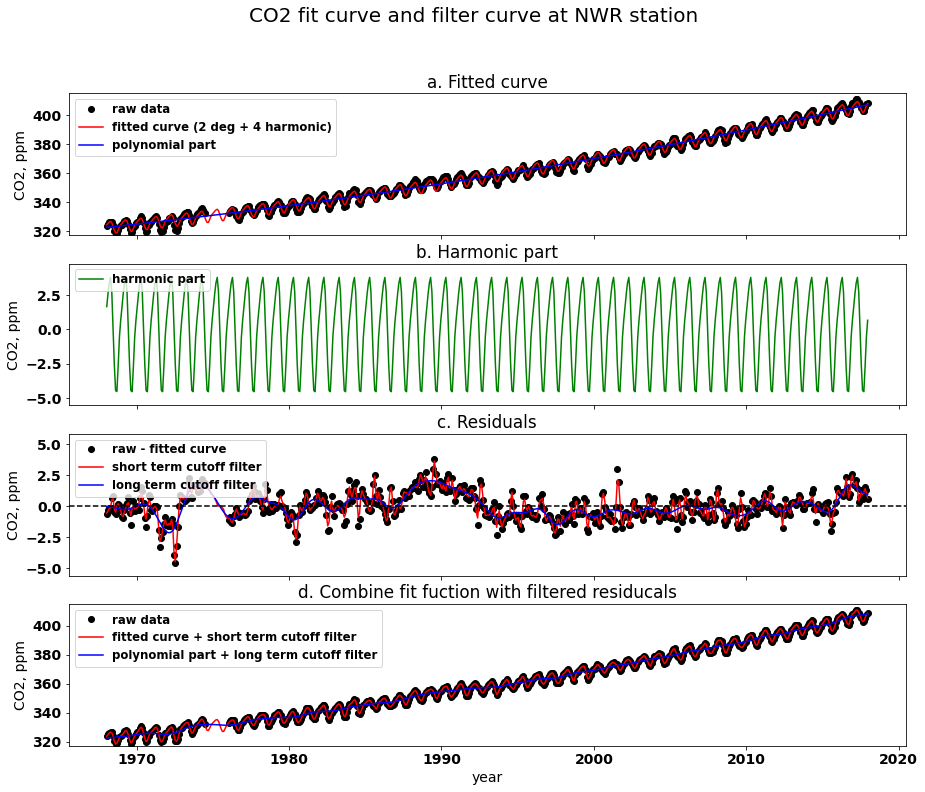

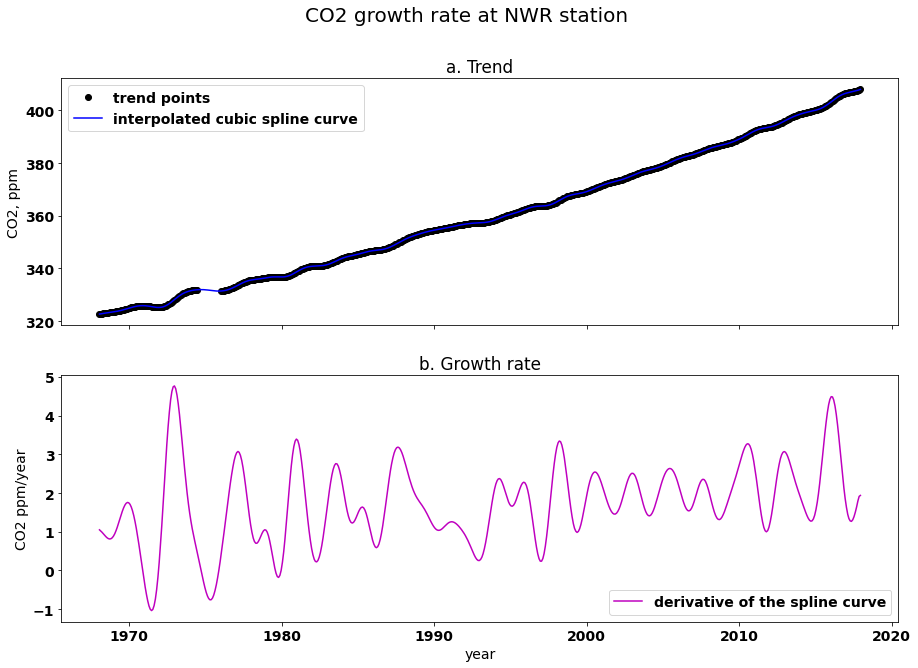

In [83]:
# set path of input and output
IN_PATH = "D:\\MyData\\jupter\\icos\\wdcgg_obs\\input\\"
OUT_PATH = "D:\\MyData\\jupter\\icos\\wdcgg_obs\\output\\"

# decide if plot, and which station
ifplot = 1
station_patten = "nwr"
station = "NWR"

# apply fit function and filter to CO2 data at each station
filenames = listdir(IN_PATH)
for file in filenames:
    apply_fit_filter(IN_PATH, file, OUT_PATH, ifplot, station_patten, station, source="wdcgg", from2000=False)

# Organize the CO2 output from WDCGG analysis (from Mikio UENO)

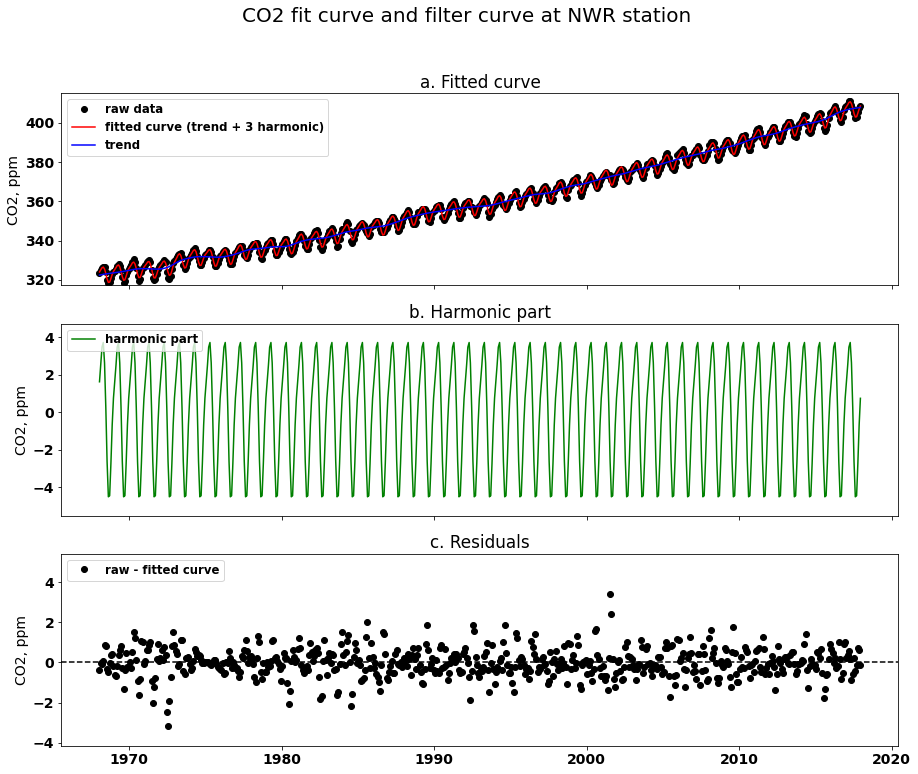

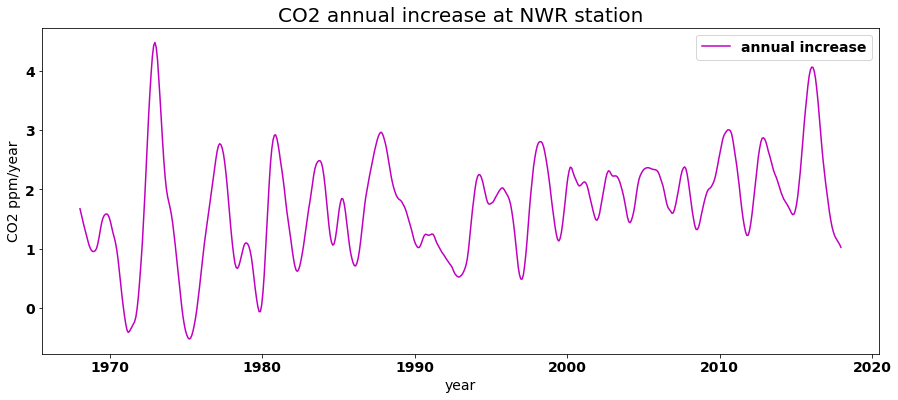

In [84]:
# set path of input and output
IN_PATH = "D:\\MyData\\jupter\\icos\\wdcgg_obs\\ti_missfl\\"
OUT_PATH = "D:\\MyData\\jupter\\icos\\wdcgg_obs\\outputMikio\\"

# decide if plot, and which station
ifplot = 1
station_patten = "nwr"
station = "NWR"

filenames = listdir(IN_PATH)
for file in filenames:

    pre_filename = file.split(".")[0].lower()
    dat = pd.read_table(IN_PATH+file, header=None, delimiter="\s+", usecols=range(8))
    dat.columns = ["yy","mm","co2","trend","seasonality","co2_cal","resid","growth_rate"]

    dat["date"] = pd.to_datetime(dat.yy*10000+dat.mm*100+15,format='%Y%m%d')
    dat["decimalyear"] = decimalDate_ymd(dat.yy, dat.mm, 15)
    
    # for fit plot
    xp = dat.decimalyear
    yp = dat.co2
    y1 = dat.co2_cal
    y2 = dat.trend
    harmonics = dat.seasonality
    resid_from_func = dat.resid
    if ifplot and station_patten in pre_filename:
        plot_fit_wdcgg (xp, yp, y1, y2, harmonics, resid_from_func, station)
        plot_growthrate_wdcgg(xp, dat.growth_rate, station)
  
    # save the file
    dat.to_csv(OUT_PATH + pre_filename + ".csv", header=True,index=False, na_rep= "NaN")


# Apply fit function and filter for Carbon tracker model output at 129 WDCGG locations 

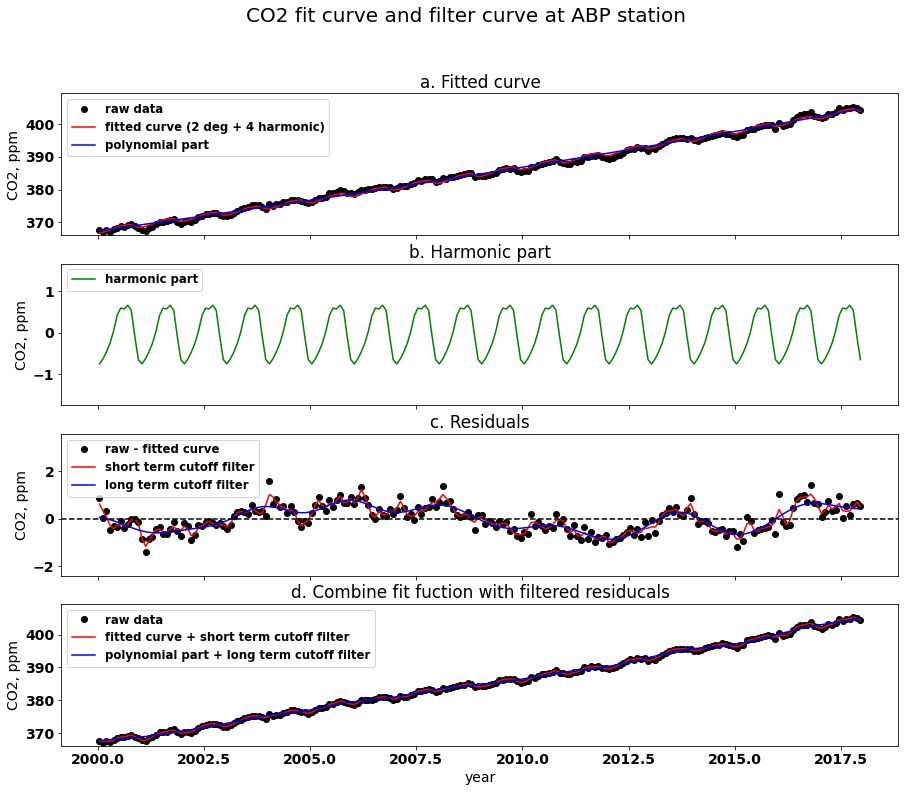

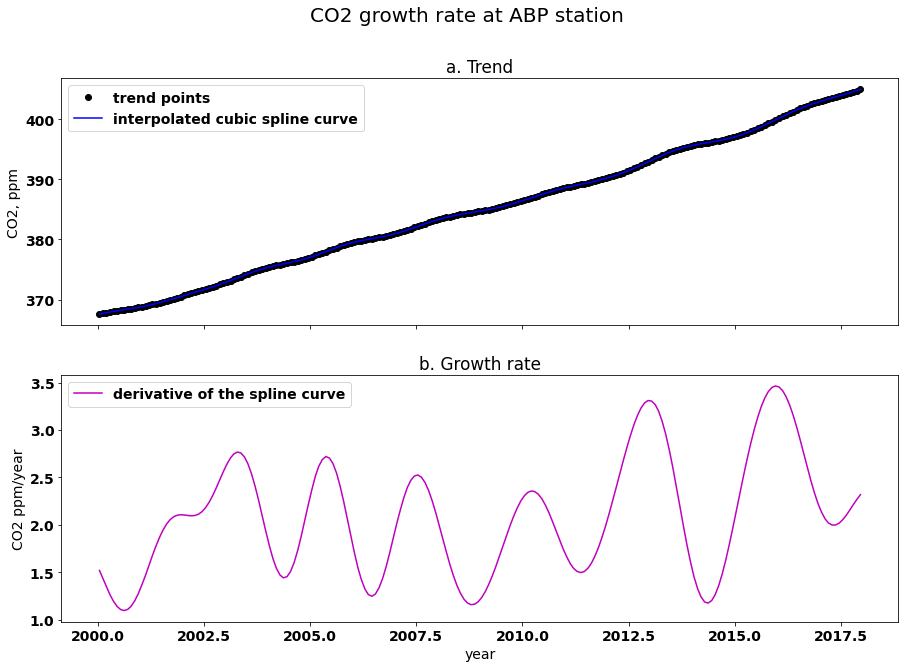

In [85]:
# set path of input and output
IN_PATH = "D:\\MyData\\jupter\\icos\\ctracker_model\\input129\\"
OUT_PATH = "D:\\MyData\\jupter\\icos\\ctracker_model\\output129\\"

# decide if plot, and which station
ifplot = 1
station_patten = "abp"
station = "ABP"

# apply fit function and filter to CO2 data at each station
filenames = listdir(IN_PATH)
for file in filenames:
    apply_fit_filter(IN_PATH, file, OUT_PATH, ifplot, station_patten, station)

# Apply fit function and filter for Carbon tracker model output at each grid of the world
### (<font color=red>This cell can not be run in github, due to the input data is too large to upload to github</font>)

0...100...200...300...400...500...600...700...800...900...1000...1100...1200...1300...1400...1500...1600...1700...1800...1900...2000...2100...2200...2300...2400...2500...2600...2700...2800...2900...3000...3100...3200...3300...3400...3500...3600...3700...3800...3900...4000...4100...4200...4300...4400...4500...4600...4700...4800...4900...5000...5100...5200...5300...5400...5500...5600...5700...5800...5900...6000...6100...6200...6300...6400...6500...6600...6700...6800...6900...7000...7100...7200...7300...7400...7500...7600...7700...7800...7900...8000...8100...8200...8300...8400...8500...8600...8700...8800...8900...9000...9100...9200...9300...9400...9500...9600...9700...9800...9900...10000...10100...10200...10300...10400...10500...10600...10700...10800...10900...11000...11100...11200...11300...11400...11500...11600...11700...11800...11900...12000...12100...12200...12300...12400...12500...12600...12700...12800...12900...13000...13100...13200...13300...13400...13500...13600...13700...13800...

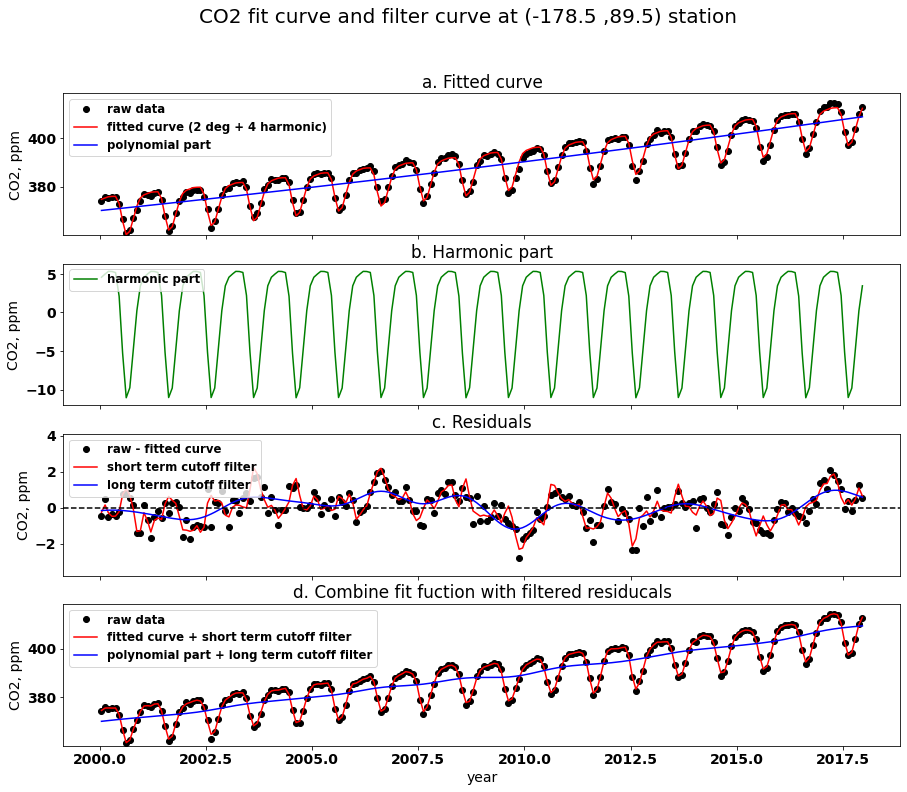

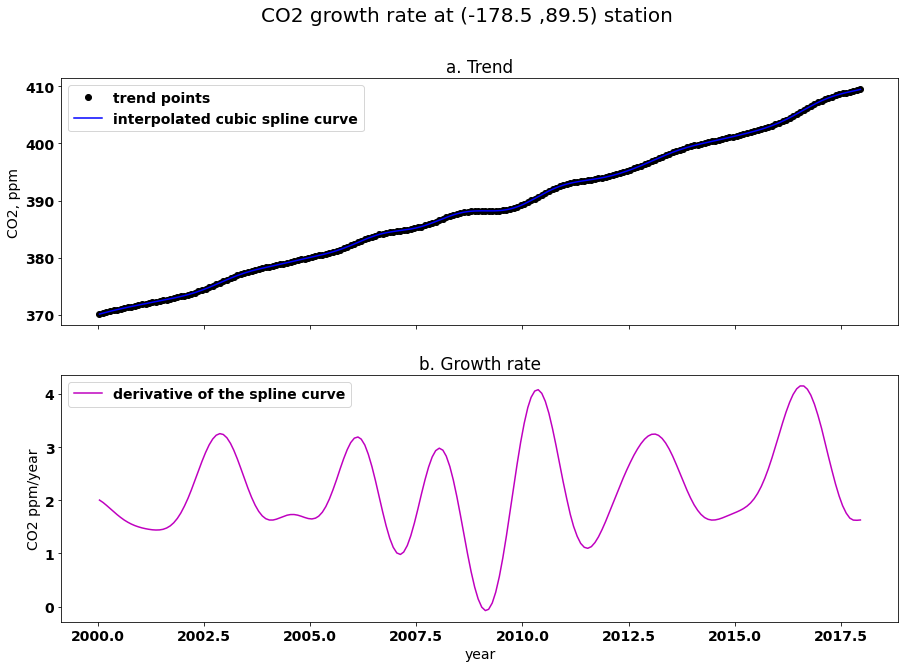

In [9]:
# set path of input and output
IN_PATH = "D:\\MyData\\jupter\\icos\\ctracker_model\\inputglobal\\"
OUT_PATH = "D:\\MyData\\jupter\\icos\\ctracker_model\\outputglobal\\"

ifplot = 1
whichgrid = 1

df_datetime = pd.DataFrame()
df_datetime["date"] = pd.date_range(start='2000-01-01', end='2017-12-31', freq="M")
df_datetime.date = df_datetime.date.apply(lambda dt: dt.replace(day=15))
df_datetime['decimalyear'] = decimalDate_datetime(df_datetime.date)

file = "CT2018_co2_2000_2017_monthly_fullglobal_level1.txt"
dat = pd.read_table(IN_PATH+file, delimiter="\s+")
dat.columns = ["lon", "lat"] + [d.strftime('%Y-%m-%d') for d in df_datetime["date"]]

df_co2_raw = pd.DataFrame()
df_co2_cal = pd.DataFrame()
df_co2rate_cal = pd.DataFrame()
for i in range(dat.shape[0]):  
    ################################################################################################ 
    # apply fit fuction and filter 
    ################################################################################################ 
    xp = df_datetime.decimalyear
    yp = dat.iloc[i,2:]
    try:
        filt = ccg_filter.ccgFilter(xp, yp, shortterm=80, longterm=667, sampleinterval=0,
                            numpolyterms=3, numharmonics=4, timezero=-1, gap=0, use_gain_factor=False, debug=False,)
    except:
        print(f"error at this grid ({dat.iloc[i,0]}, {dat.iloc[i,1]})")
    
    station = "(" + str(dat.iloc[i,0]) + " ," + str(dat.iloc[i,1]) +")"

    # for fit plot
    x0 = df_datetime.decimalyear
    y1 = filt.getFunctionValue(x0)
    y2 = filt.getPolyValue(x0)
    y3 = filt.getSmoothValue(x0)
    y4 = filt.getTrendValue(x0)
    harmonics = filt.getHarmonicValue(x0)
    resid_from_func = np.array(yp) - np.array(y1)
    resid_smooth = y3 - y1
    resid_trend = y4 -y2
    if ifplot and whichgrid == i:
        plot_fit(xp, yp, x0, y1, y2, harmonics, resid_from_func, resid_smooth, resid_trend, station)
    
    # for growth rate plot
    trendp = filt.getTrendValue(xp)
    tck = sp.interpolate.splrep(x0, y4)
    trend_spl = sp.interpolate.splev(x0, tck)
    trend_der1 = sp.interpolate.splev(x0, tck, der=1)
    if ifplot and whichgrid == i:
        plot_growthrate(xp, trendp, x0, trend_spl, trend_der1, station)
    
    ################################################################################################    
    # save the file
    ################################################################################################ 
    record = pd.concat([dat.iloc[i,:2],yp],axis=0)
    df_co2_raw = pd.concat([df_co2_raw,record],axis=1)
    
    record = pd.concat([dat.iloc[i,:2],y1+resid_smooth],axis=0)
    df_co2_cal = pd.concat([df_co2_cal,record],axis=1)
    
    record = pd.concat([dat.iloc[i,:2],pd.DataFrame(trend_der1)],axis=0)
    df_co2rate_cal = pd.concat([df_co2rate_cal,record],axis=1)
    
    if i % 100 ==0:
        print(i, end="...")
print("done")
    
df_co2_raw = df_co2_raw.T    
df_co2_cal = df_co2_cal.T 
df_co2rate_cal = df_co2rate_cal.T 

df_co2_raw.columns = ["lon", "lat"] + [d.strftime('%Y-%m-%d') for d in df_datetime["date"]]
df_co2_cal.columns = ["lon", "lat"] + [d.strftime('%Y-%m-%d') for d in df_datetime["date"]]
df_co2rate_cal.columns = ["lon", "lat"] + [d.strftime('%Y-%m-%d') for d in df_datetime["date"]]

df_co2_raw.to_csv(OUT_PATH + "CT2018_raw_co2_2000_2017_monthly_fullglobal_level1.csv", header=True,index=False, na_rep= "NaN")
df_co2_cal.to_csv(OUT_PATH + "CT2018_cal_co2_2000_2017_monthly_fullglobal_level1.csv", header=True,index=False, na_rep= "NaN")
df_co2rate_cal.to_csv(OUT_PATH + "CT2018_cal_co2rate_2000_2017_monthly_fullglobal_level1.csv", header=True,index=False, na_rep= "NaN")


# Following cell is used for testing (not part of the code)

In [ ]:
# # set path of input and output
# IN_PATH = "D:\\MyData\\jupter\\icos\\ctracker_obs\\input\\"
# OUT_PATH = "D:\\MyData\\jupter\\icos\\ctracker_obs\\output\\"

# IN_PATH = "D:\\MyData\\jupter\\icos\\\wdcgg_obs\\input\\"
# OUT_PATH = "D:\\MyData\\jupter\\icos\\\wdcgg_obs\\output\\"

# source = "wdcgg"
# from2000 = True

# # decide if plot, and which station
# ifplot = 1
# station_patten = "_bir_"
# station = "BIR"
# station_patten = "abp"
# station = "ABP"

# filenames = listdir(IN_PATH)
# for file in filenames[2:3]:
#     ################################################################################################ 
#     # mark if it is measured in shipboard
#     ################################################################################################ 
#     pre_filename = file.split(".")[0]
#     shipboard = 0
#     if any(item in pre_filename for item in ['shipboard', 'poc8', 'scs8']):
#         shipboard = 1
    
#     ################################################################################################ 
#     # read data and primary data clean
#     ################################################################################################ 
#     if source == "wdcgg":
#         dat = pd.read_table(IN_PATH+file, delimiter="\s+", skiprows=24)
#         dat = dat.reset_index()
#         dat = dat.iloc[:,0:3]
#         dat.columns = ['yy','mm','co2']
#     else:
#         dat = pd.read_table(IN_PATH+file, delimiter="\s+")
    
#     # set outlier to NaN
#     dat.loc[(dat["co2"]>1000) | (dat["co2"]<0),"co2"] = np.nan
#     dat = dat.loc[~np.isnan(dat.co2)]
    
#     # get monthly mean
#     df_monthly = dat.groupby(["yy","mm"])["co2"].mean().sort_index(ascending=True)
    
#     # trim leading and trailing NAs 
#     first_valid = df_monthly[df_monthly.notnull()].index[0]
#     last_valid = df_monthly[df_monthly.notnull()].index[-1]
#     df_monthly = df_monthly.loc[first_valid:last_valid]

#     # set date and decimal date
#     df_monthly = df_monthly.reset_index()
#     df_monthly["date"] = pd.to_datetime(df_monthly.yy*10000+df_monthly.mm*100+15,format='%Y%m%d')
#     df_monthly["decimalyear"] = decimalDate_ymd(df_monthly.yy, df_monthly.mm, 15)
#     if from2000 == True:
#         df_monthly = df_monthly[df_monthly.date > "2000-1-1"]
#     df_monthly = df_monthly.set_index("date")
#     ################################################################################################ 
#     # apply fit fuction and filter 
#     ################################################################################################ 
#     xp = df_monthly["decimalyear"]
#     yp = df_monthly["co2"]

#     # skip the station which has less than 12 monthes data
#     if len(xp) < 12:
#         print(f"There is only {len(xp)} monthes data at this station ({pre_filename}), skip")
#         continue
    
#     # set shortterm cutoff as 200 for the measurement on shipboard
#     if shipboard == 0:
#         try:
#             filt = ccg_filter.ccgFilter(xp, yp, shortterm=80, longterm=667, sampleinterval=0,
#                                 numpolyterms=3, numharmonics=4, timezero=-1, gap=0, use_gain_factor=False, debug=False,)
#         except:
#             print(f"error at this station ({pre_filename})")
#     else:
#         #https://www.esrl.noaa.gov/gmd/webdata/ccgg/trends/co2_DEconfig.txt
#         try:
#             filt = ccg_filter.ccgFilter(xp, yp, shortterm=200, longterm=667, sampleinterval=0,
#                                 numpolyterms=3, numharmonics=4, timezero=-1, gap=0, use_gain_factor=False, debug=False,)
#         except:
#             print(f"error at this station ({pre_filename})")
    
#     # check if the numharmonics is appropriate
#     # e.g. station FPK, no 62, gives extreme harmonic/seasonality, the numharmonics needs to reduce
#     x0 = filt.xinterp
#     harmonics = filt.getHarmonicValue(x0)
#     if abs(harmonics.sum()) > 500:
#         print(f"The numharmonics setting causes extreme output at this station ({pre_filename}), skip")
#         print(f"The harmonics are: {harmonics}")
#         print(f"The solution is to reduce numharmonics, e.g. 3 or 2, here we just exclude this station data")
#         continue
    
    
#     ################################################################################################ 
#     # estimate co2 during full period 
#     ################################################################################################ 
#     df_fullmonthly = df_monthly.resample('M').mean().reset_index()
#     df_fullmonthly.date = df_fullmonthly.date.apply(lambda dt: dt.replace(day=15))
#     df_fullmonthly.decimalyear = decimalDate_ymd(df_fullmonthly.date.dt.year, df_fullmonthly.date.dt.month, 15)
    
#     # for fit plot
#     x0 = df_fullmonthly.decimalyear
#     y1 = filt.getFunctionValue(x0)
#     y2 = filt.getPolyValue(x0)
#     y3 = filt.getSmoothValue(x0)
#     y4 = filt.getTrendValue(x0)
#     harmonics = filt.getHarmonicValue(x0)
#     resid_from_func = df_fullmonthly.co2 - y1
#     resid_smooth = y3 - y1
#     resid_trend = y4 -y2
#     if ifplot and station_patten in pre_filename:
#         plot_fit(xp, yp, x0, y1, y2, harmonics, resid_from_func, resid_smooth, resid_trend, station)
    
#     # for growth rate plot
#     trendp = filt.getTrendValue(xp)
#     tck = sp.interpolate.splrep(x0, y4)
#     trend_spl = sp.interpolate.splev(x0, tck)
#     trend_der1 = sp.interpolate.splev(x0, tck, der=1)
#     if ifplot and station_patten in pre_filename:
#         plot_growthrate(xp, trendp, x0, trend_spl, trend_der1, station)
#     ################################################################################################    
#     # save the file
#     ################################################################################################ 
#     df_fullmonthly["polypart"] = y2
#     df_fullmonthly["harmpart"] = harmonics
#     df_fullmonthly["resid"] = resid_from_func
#     df_fullmonthly["resid_smooth"] = resid_smooth
#     df_fullmonthly["resid_trend"] = resid_trend
#     df_fullmonthly["growth_rate"] = trend_der1
    
#     df_fullmonthly.to_csv(OUT_PATH + pre_filename + "_fit_filter.csv", header=True,index=False, na_rep= "NaN")
    
# #     np.savetxt(pre_filename + "_fit_filter", df_fullmonthly, fmt='%d')

